In [1]:
import torch, tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

def Accuracy(TRUTH, PREDICTION, BATCH_SIZE):
    return (TRUTH==PREDICTION).sum().item()/BATCH_SIZE

# Transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),]
)

GPU State: cuda:0


In [2]:
# Data
valid_size=0.2
shuffle = True
random_seed = 100
trainSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
valSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
testSet = datasets.MNIST(root='MNIST', download=True, train=False, transform=transform)

num_train = len(trainSet)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=64, sampler=train_sampler)
valLoader = torch.utils.data.DataLoader(valSet, batch_size=64, sampler=valid_sampler)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)

In [3]:
# Model
class Shallow_Net(torch.nn.Module):
    def __init__(self):
        super(Shallow_Net, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=20*144, out_features=10),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)

class Shallow_Net_1(torch.nn.Module):
    def __init__(self):
        super(Shallow_Net_1, self).__init__()
        self.conv2d_1 = torch.nn.Conv2d(1, 10, 3, 1)
        self.conv2d_2 = torch.nn.Conv2d(10, 20, 3, 1)
        self.fc1 = torch.nn.Linear(20*144, 10)
#         self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv2d_1(x)
        x = F.relu(x)
        x = self.conv2d_2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        output = F.log_softmax(x, dim=1)
        return output
    
net_1 = Shallow_Net().to(device)
net_2 = Shallow_Net_1().to(device)
# net_3 = Shallow_Net_2().to(device)
print(net_1)
print(net_2)
# print(net_3)

Shallow_Net(
  (main): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
    (6): Linear(in_features=2880, out_features=10, bias=True)
    (7): LogSoftmax(dim=1)
  )
)
Shallow_Net_1(
  (conv2d_1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2d_2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2880, out_features=10, bias=True)
)


In [4]:
def train_fn(epochs, lr, optimizer_name, net, name_of_net):
    criterion = torch.nn.CrossEntropyLoss()
    if optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
    else : 
        print("Error, please input 'SGD' or Adam.")
    # Train
    epoch_loss = []
    epoch_acc = []
    epoch_val_loss = []
    epoch_val_acc = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_acc = 0.0
        running_loss_val = 0.0
        running_acc_val = 0.0
        
        for times, data in enumerate(trainLoader):
            net.train()
#             print("Training")
            inputs, labels = data[0].to(device), data[1].to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Foward + backward + optimize
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            running_acc += Accuracy(labels, predicted, trainLoader.batch_size)
#             if times % 100 == 99 or times+1 == len(trainLoader):
#                 print('[%d/%d, %d/%d] loss: %.3f' % (epoch+1, epochs, times+1, len(trainLoader), running_loss/2000))
        with torch.no_grad():
            net.eval()
#             print("Validating.")
            for times_val, data_val in enumerate(valLoader):
                inputs_val, labels_val = data_val[0].to(device), data_val[1].to(device)
        #         inputs = inputs.view(inputs.shape[0], -1)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Foward + backward + optimize
                outputs_val = net(inputs_val)
                _, predicted_val = torch.max(outputs_val.data, 1)
                loss_val = criterion(outputs_val, labels_val)
#                     loss_val.backward()
#                     optimizer.step()

                # Print statistics
                running_loss_val += loss_val.item()
                running_acc_val += Accuracy(labels_val, predicted_val, valLoader.batch_size)
            _epoch_val_loss = running_loss_val/len(valLoader)
            _epoch_val_acc = running_acc_val/len(valLoader)
            epoch_val_loss.append(_epoch_val_loss)
            epoch_val_acc.append(_epoch_val_acc)
                
        _epoch_loss = running_loss/len(trainLoader)
        _epoch_acc = running_acc/len(trainLoader)
        epoch_loss.append(_epoch_loss)
        epoch_acc.append(_epoch_acc)
        print("Epoch: {0}, loss: {1:.3f}, acc: {2:.3f}, val_loss: {3:.3f}, val_acc: {4:.3f}".format(epoch+1, _epoch_loss, _epoch_acc, _epoch_val_loss, _epoch_val_acc))
    print('Training Finished.')
    
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testLoader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct / total))

    class_correct = [0 for i in range(10)]
    class_total = [0 for i in range(10)]

    with torch.no_grad():
        net.eval()
        for data in testLoader:
            inputs, labels = data[0].to(device), data[1].to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(10):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    #             print(class_correct)
    #             print(class_total)

    for i in range(10):
        print('Accuracy of %d: %3f' % (i, (class_correct[i]/class_total[i])))
    acc = (100*correct / total)
    x = np.linspace(1, epochs, num = epochs)
    plt.plot(x, epoch_acc, label='acc')
    plt.plot(x, epoch_loss, label='loss')
    plt.plot(x, epoch_val_loss, label='val_loss')
    plt.plot(x, epoch_val_acc, label='val_acc')
    plt.xlabel('epochs')
    plt.ylabel('acc/loss')
    plt.legend(loc="upper right")
    plt.savefig("mnist_cnn_"+optimizer_name+str(name_of_net)+"_ce_shallow_"+str(int(acc))+".png")
    plt.show()

Epoch: 1, loss: 0.174, acc: 0.947, val_loss: 0.073, val_acc: 0.975
Epoch: 2, loss: 0.057, acc: 0.983, val_loss: 0.061, val_acc: 0.979
Epoch: 3, loss: 0.042, acc: 0.987, val_loss: 0.058, val_acc: 0.980
Epoch: 4, loss: 0.032, acc: 0.990, val_loss: 0.053, val_acc: 0.983
Epoch: 5, loss: 0.025, acc: 0.992, val_loss: 0.052, val_acc: 0.983
Epoch: 6, loss: 0.020, acc: 0.994, val_loss: 0.058, val_acc: 0.983
Epoch: 7, loss: 0.016, acc: 0.995, val_loss: 0.055, val_acc: 0.982
Epoch: 8, loss: 0.014, acc: 0.995, val_loss: 0.059, val_acc: 0.984
Epoch: 9, loss: 0.011, acc: 0.997, val_loss: 0.065, val_acc: 0.982
Epoch: 10, loss: 0.009, acc: 0.997, val_loss: 0.069, val_acc: 0.982
Training Finished.
Accuracy of the network on the 10000 test images: 98 %
Accuracy of 0: 0.986842
Accuracy of 1: 0.972973
Accuracy of 2: 0.976744
Accuracy of 3: 0.980769
Accuracy of 4: 0.960452
Accuracy of 5: 0.976190
Accuracy of 6: 0.976562
Accuracy of 7: 0.993902
Accuracy of 8: 1.000000
Accuracy of 9: 0.994012


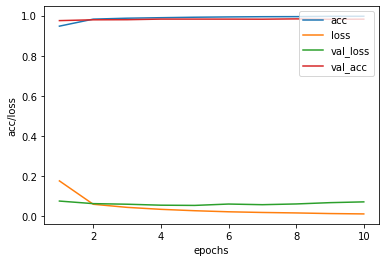

In [5]:
train_fn(10, 0.01, "Adam", net_1, "_with_maxpooling")

Epoch: 1, loss: 0.191, acc: 0.943, val_loss: 0.103, val_acc: 0.968
Epoch: 2, loss: 0.065, acc: 0.980, val_loss: 0.060, val_acc: 0.980
Epoch: 3, loss: 0.046, acc: 0.986, val_loss: 0.059, val_acc: 0.980
Epoch: 4, loss: 0.034, acc: 0.989, val_loss: 0.056, val_acc: 0.981
Epoch: 5, loss: 0.026, acc: 0.992, val_loss: 0.058, val_acc: 0.981
Epoch: 6, loss: 0.020, acc: 0.993, val_loss: 0.064, val_acc: 0.980
Epoch: 7, loss: 0.017, acc: 0.994, val_loss: 0.062, val_acc: 0.982
Epoch: 8, loss: 0.013, acc: 0.995, val_loss: 0.072, val_acc: 0.981
Epoch: 9, loss: 0.012, acc: 0.996, val_loss: 0.073, val_acc: 0.982
Epoch: 10, loss: 0.010, acc: 0.996, val_loss: 0.083, val_acc: 0.981
Training Finished.
Accuracy of the network on the 10000 test images: 98 %
Accuracy of 0: 0.986842
Accuracy of 1: 0.983784
Accuracy of 2: 0.982558
Accuracy of 3: 0.974359
Accuracy of 4: 0.977401
Accuracy of 5: 0.984127
Accuracy of 6: 0.968750
Accuracy of 7: 0.951220
Accuracy of 8: 0.972028
Accuracy of 9: 0.994012


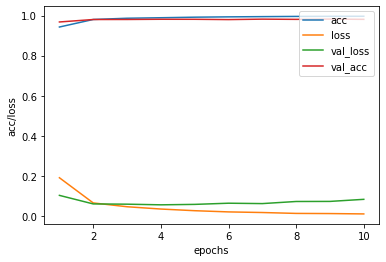

In [5]:
train_fn(10, 0.01, "Adam", net_2, "_with_maxpooling_method_2.png")